# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import re
import nltk
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import os

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/50k-celebrity-faces-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 333M/333M [00:16<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1


In [3]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1/Celebrity_Faces_Dataset"

print(os.listdir(dataset_path)[:10])
print("Total files:", len(os.listdir(dataset_path)))


['017793.jpg', '021605.jpg', '013663.jpg', '025934.jpg', '045791.jpg', '012884.jpg', '035539.jpg', '021201.jpg', '045350.jpg', '008064.jpg']
Total files: 50000


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

# Path to images
dataset_path = "/root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1/Celebrity_Faces_Dataset"

# Hyperparameters
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 3  # RGB

# Transformations (Normalize to [-1,1])
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*CHANNELS, [0.5]*CHANNELS)
])

# Custom Dataset
class CelebDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.png','.jpg','.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Load Dataset
dataset = CelebDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Check
print("Dataset size:", len(dataset))
print("Number of batches:", len(dataloader))


Dataset size: 50000
Number of batches: 391


show data sample

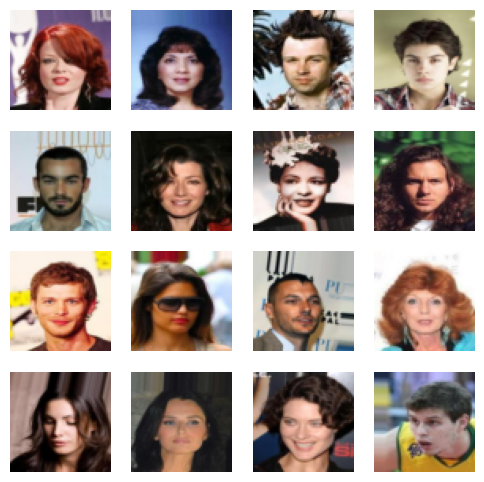

In [5]:

def show_images(batch):
    # batch: Tensor [B, C, H, W]
    grid = batch[:16].clone().detach()
    grid = (grid * 0.5) + 0.5  # unnormalize from [-1,1] to [0,1]
    grid = grid.permute(0, 2, 3, 1).numpy()  # [B, H, W, C] for matplotlib

    fig, axs = plt.subplots(4, 4, figsize=(6,6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(grid[i])
        ax.axis("off")
    plt.show()


batch = next(iter(dataloader))
show_images(batch)


# Data preprocessing


study data

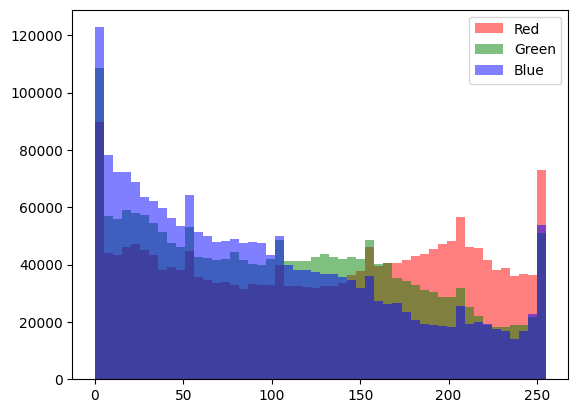

In [6]:

# Use dataset.image_files which contains all image paths
sample_files = random.sample(dataset.image_files, 500)
r_vals, g_vals, b_vals = [], [], []

for f in sample_files:
    img = Image.open(f).convert("RGB").resize((64,64)) # f already contains the full path
    arr = np.array(img)
    r_vals.extend(arr[:,:,0].flatten())
    g_vals.extend(arr[:,:,1].flatten())
    b_vals.extend(arr[:,:,2].flatten())

plt.hist(r_vals, bins=50, alpha=0.5, color='r', label='Red')
plt.hist(g_vals, bins=50, alpha=0.5, color='g', label='Green')
plt.hist(b_vals, bins=50, alpha=0.5, color='b', label='Blue')
plt.legend()
plt.show()


In [7]:
IMAGE_SIZE = 64
CHANNELS = 3  # RGB

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),   # Resize all images
    transforms.ToTensor(),                        # Convert to tensor [0,1]
    transforms.Normalize([0.5]*CHANNELS, [0.5]*CHANNELS)  # Normalize to [-1,1]
])


# ML Models

Autoencoder

In [8]:
import torch
import torch.nn as nn

latent_dim = 100
channels = 3
ngf = 64
ndf = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# Encoder
# -------------------
class Encoder(nn.Module):
    def __init__(self, channels, latent_dim, ndf=64):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),     # 32x32 -> 16x16
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),   # 16x16 -> 8x8
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1),   # 8x8 -> 4x4
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, latent_dim, 4, 1, 0), # 4x4 -> 1x1
        )

    def forward(self, x):
        z = self.main(x)
        return z.view(-1, latent_dim, 1, 1)

# -------------------
# Decoder / Generator
# -------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, ngf=64):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# -------------------
# Discriminator
# -------------------
class Discriminator(nn.Module):
    def __init__(self, channels, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0),
        )

    def forward(self, x):
        return self.main(x).view(-1)


Initialize weights

In [9]:
encoder = Encoder(channels, latent_dim).to(device)
decoder = Decoder(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)


model train

In [10]:
import torch.optim as optim
import torch.nn as nn

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
reconstruction_loss = nn.L1Loss()

# Optimizers
lr = 0.0002
beta1 = 0.5

optimizer_EG = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=lr, betas=(beta1, 0.999)
)

optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=lr, betas=(beta1, 0.999)
)


In [11]:
from torchvision.utils import save_image
import os
from tqdm import tqdm

epochs = 25
lambda_recon = 100  # وزن إعادة البناء
save_dir = "/content/AE_GAN_results"
os.makedirs(save_dir, exist_ok=True)

real_label = 1.0
fake_label = 0.0

fixed_images = next(iter(dataloader)).to(device)[:16]

for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for i, real_imgs in enumerate(loop):
        real_imgs = real_imgs.to(device)
        b_size = real_imgs.size(0)

        real_labels = torch.full((b_size,), real_label, device=device)
        fake_labels = torch.full((b_size,), fake_label, device=device)

        # ======================
        # (1) Train Discriminator
        # ======================
        discriminator.zero_grad()

        # Real images
        output_real = discriminator(real_imgs)
        loss_D_real = adversarial_loss(output_real, real_labels)

        # Fake images (reconstructed)
        z = encoder(real_imgs)
        fake_imgs = decoder(z)
        output_fake = discriminator(fake_imgs.detach())
        loss_D_fake = adversarial_loss(output_fake, fake_labels)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # ======================
        # (2) Train Encoder + Generator
        # ======================
        encoder.zero_grad()
        decoder.zero_grad()

        output_fake = discriminator(fake_imgs)
        loss_G_adv = adversarial_loss(output_fake, real_labels)
        loss_G_recon = reconstruction_loss(fake_imgs, real_imgs)

        loss_EG = loss_G_adv + lambda_recon * loss_G_recon
        loss_EG.backward()
        optimizer_EG.step()

        loop.set_postfix(loss_D=loss_D.item(), loss_EG=loss_EG.item())




Epoch [25/25]: 100%|██████████| 391/391 [01:19<00:00,  4.89it/s, loss_D=0.563, loss_EG=17.2]


# model validation

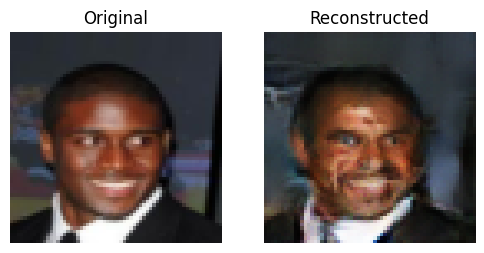

In [13]:
import matplotlib.pyplot as plt

# Ensure models are in evaluation mode
encoder.eval()
decoder.eval()

# Generate reconstructed images from fixed_images
with torch.no_grad():
    z_fixed = encoder(fixed_images.to(device))
    recon = decoder(z_fixed).cpu() # Move to CPU for plotting

img_real = fixed_images[0].cpu()
img_fake = recon[0]

img_real = (img_real * 0.5 + 0.5).permute(1,2,0)
img_fake = (img_fake * 0.5 + 0.5).permute(1,2,0) # Unnormalize fake image as well

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_real)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(img_fake)
plt.axis("off")
plt.show()

# deployment

save model

In [20]:
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")
print("Models saved successfully!")

Models saved successfully!


loading

In [15]:
encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

encoder.eval()
decoder.eval()


Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

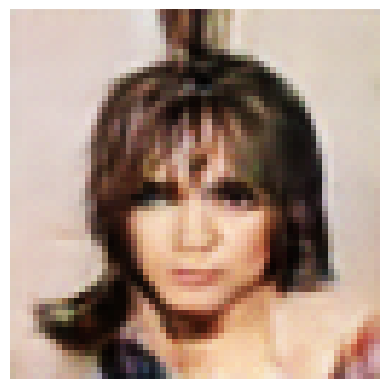

In [16]:
import matplotlib.pyplot as plt

# أخذ صورة من الداتا أو صورة جديدة
real_img = next(iter(dataloader))[0].unsqueeze(0).to(device)

with torch.no_grad():
    z = encoder(real_img)
    generated = decoder(z)

# عرض الصورة
img = (generated[0] * 0.5 + 0.5).permute(1,2,0).cpu().numpy()

plt.imshow(img)
plt.axis("off")
plt.show()


Streamlit

In [18]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.2 MB/s eta 0:00:00


In [21]:
import streamlit as st
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# =====================
# Page config
# =====================
st.set_page_config(
    page_title="Autoencoder GAN | Face Generator",
    page_icon="🧠",
    layout="centered"
)

st.title("🧠 Autoencoder GAN – Face Generator")
st.markdown("Generate and reconstruct human faces using a trained Autoencoder-GAN model.")

# =====================
# Device
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# Model Architectures (copying from previous cells to make this cell self-contained)
# =====================
import torch.nn as nn

latent_dim = 100
channels = 3 # RGB
ngf = 64
ndf = 64

class Encoder(nn.Module):
    def __init__(self, channels, latent_dim, ndf=64):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),     # 32x32 -> 16x16
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),   # 16x16 -> 8x8
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1),   # 8x8 -> 4x4
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, latent_dim, 4, 1, 0), # 4x4 -> 1x1
        )

    def forward(self, x):
        z = self.main(x)
        return z.view(-1, latent_dim, 1, 1)

class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, ngf=64):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# =====================
# Load Models
# =====================
@st.cache_resource
def load_models():
    # Instantiate the models first
    encoder = Encoder(channels, latent_dim, ndf).to(device)
    decoder = Decoder(latent_dim, channels, ngf).to(device)

    # Load the state dictionaries
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    encoder.eval()
    decoder.eval()
    return encoder, decoder

encoder, decoder = load_models()

# =====================
# Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# =====================
# Sidebar
# =====================
st.sidebar.title("⚙️ Options")
mode = st.sidebar.radio(
    "Choose Mode:",
    ("Generate from Noise", "Reconstruct Image")
)

# =====================
# Generate from Noise
# =====================
if mode == "Generate from Noise":
    st.subheader("🎲 Generate New Face")

    if st.button("Generate Face"):
        noise = torch.randn(1, latent_dim, 1, 1).to(device)

        with torch.no_grad():
            fake = decoder(noise)

        img = (fake[0]*0.5 + 0.5).permute(1,2,0).cpu().numpy()

        st.image(img, caption="Generated Face", use_column_width=True)

# =====================
# Reconstruct Image
# =====================
else:
    st.subheader("🖼 Reconstruct Face")

    uploaded_file = st.file_uploader(
        "Upload a face image",
        type=["jpg", "png", "jpeg"]
    )

    if uploaded_file:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Original Image", use_column_width=True)

        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            z = encoder(img_tensor)
            reconstructed = decoder(z)

        recon_img = (reconstructed[0]*0.5 + 0.5).permute(1,2,0).cpu().numpy()

        st.image(recon_img, caption="Reconstructed Image", use_column_width=True)

# =====================
# Footer
# =====================
st.markdown("---")
st.markdown(
    "<center>Autoencoder-GAN Deployment | Deep Learning Project</center>",
    unsafe_allow_html=True
)

2025-12-14 19:56:16.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.563 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.566 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-14 19:56:16.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [26]:
%%writefile app.py
import streamlit as st
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# =====================
# Page config
# =====================
st.set_page_config(
    page_title="Autoencoder GAN | Face Generator",
    page_icon="🧠",
    layout="centered"
)

st.title("🧠 Autoencoder GAN – Face Generator")
st.markdown("Generate and reconstruct human faces using a trained Autoencoder-GAN model.")

# =====================
# Device
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# Model Architectures (copying from previous cells to make this cell self-contained)
# =====================
import torch.nn as nn

latent_dim = 100
channels = 3 # RGB
ngf = 64
ndf = 64

class Encoder(nn.Module):
    def __init__(self, channels, latent_dim, ndf=64):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),     # 32x32 -> 16x16
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),   # 16x16 -> 8x8
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1),   # 8x8 -> 4x4
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, latent_dim, 4, 1, 0), # 4x4 -> 1x1
        )

    def forward(self, x):
        z = self.main(x)
        return z.view(-1, latent_dim, 1, 1)

class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, ngf=64):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)

# =====================
# Load Models
# =====================
@st.cache_resource
def load_models():
    # Instantiate the models first
    encoder = Encoder(channels, latent_dim, ndf).to(device)
    decoder = Decoder(latent_dim, channels, ngf).to(device)

    # Load the state dictionaries
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    encoder.eval()
    decoder.eval()
    return encoder, decoder

encoder, decoder = load_models()

# =====================
# Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# =====================
# Sidebar
# =====================
st.sidebar.title("⚙️ Options")
mode = st.sidebar.radio(
    "Choose Mode:",
    ("Generate from Noise", "Reconstruct Image")
)

# =====================
# Generate from Noise
# =====================
if mode == "Generate from Noise":
    st.subheader("🎲 Generate New Face")

    if st.button("Generate Face"):
        noise = torch.randn(1, latent_dim, 1, 1).to(device)

        with torch.no_grad():
            fake = decoder(noise)

        img = (fake[0]*0.5 + 0.5).permute(1,2,0).cpu().numpy()

        st.image(img, caption="Generated Face", use_column_width=True)

# =====================
# Reconstruct Image
# =====================
else:
    st.subheader("🖼 Reconstruct Face")

    uploaded_file = st.file_uploader(
        "Upload a face image",
        type=["jpg", "png", "jpeg"]
    )

    if uploaded_file:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Original Image", use_column_width=True)

        img_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            z = encoder(img_tensor)
            reconstructed = decoder(z)

        recon_img = (reconstructed[0]*0.5 + 0.5).permute(1,2,0).cpu().numpy()

        st.image(recon_img, caption="Reconstructed Image", use_column_width=True)

# =====================
# Footer
# =====================
st.markdown("---")
st.markdown(
    "<center>Autoencoder-GAN Deployment | Deep Learning Project</center>",
    unsafe_allow_html=True
)

!streamlit run app.py

Overwriting app.py


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.124.253.161:8501

